# Laboratorio Transformers del lenguaje

## Importante: 
**Antes de correr cualquier celda, de click en 'Widgets' y luego en 'Clear Notebook Widget State', de lo contrario no se generará una calificación para el laboratorio.**


En este laboratorio, utilizaremos una versión preentrenada de un modelo de transformer de lenguaje para procesar texto conocido como BERT. Luego, utilizaremos la salida de ese modelo para clasificar el texto. El texto consiste en una lista de oraciones de reseñas de películas. Clasificaremos cada oración como "positiva" o "negativa" y así obtendremos una clasificación de la reseña que nos dirá si la reseña expresa una opinión negativa o positiva acerca de la película. En este laboratorio veremos cómo utilizar modelos pre entrenados puede acelerar el proceso de aprendizaje y cómo podemos utilizar diferentes arquitecturas al tiempo para resolver problemas de clasificación de texto.

## Objetivo: Clasificación de Sentimientos en Oraciones


Nuestro objetivo es crear un modelo que tome una oración  y produzca ya sea un 1 (indicando que la oración expresa una opinión positiva) o un 0 (indicando que la oración expresa una opinión negativa). Podemos imaginarlo de la siguiente manera:
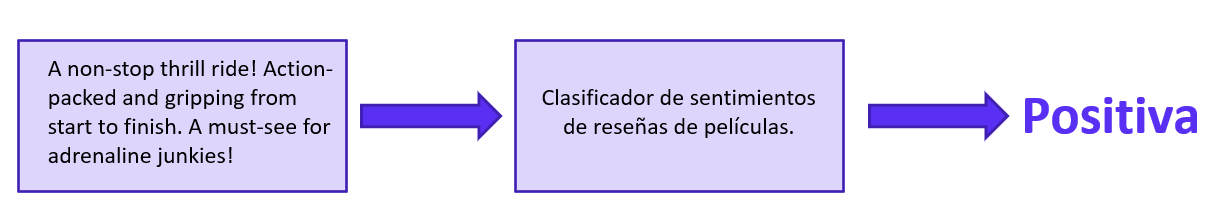

## 1.0 Ententiendo el modelo


El modelo está compuesto en realidad por dos modelos.



* DistilBERT procesa la oración y transmite alguna información que extrajo de ella al siguiente modelo. Podemos pensar que este modelo está en cierta forma preprocesando nuestros datos y encontrando una mejor representación de ellos en un espacio latente. DistilBERT es una versión más pequeña de BERT desarrollada y de código abierto por el equipo de HuggingFace. Es una versión más ligera y rápida de BERT que se aproxima a su rendimiento.
* El siguiente modelo es un modelo básico de Regresión Logística de scikit learn, que recibirá el resultado del procesamiento de DistilBERT y clasificará la oración como positiva o negativa (1 o 0, respectivamente). La regresión logística es un algoritmo de aprendizaje estadístico. Es un clasificador lineal que resuelve la tarea de clasificación binaria. Es decir, predice si un dato pertenece a la clase 1 o a la clase 0. Es un clasificador relativamente sencillo y mucho más interpretable que otros clasificadores más complejos como las redes neuronales profundas. La idea es que si utilizamos DistilBERT como una 'capa de preprocesamiento' de nuestros datos, luego podemos utilizar la regresión logística, que es un modelo bastante sencillo para clasificar de forma correcta nuestros datos y obtener una buena precisión.


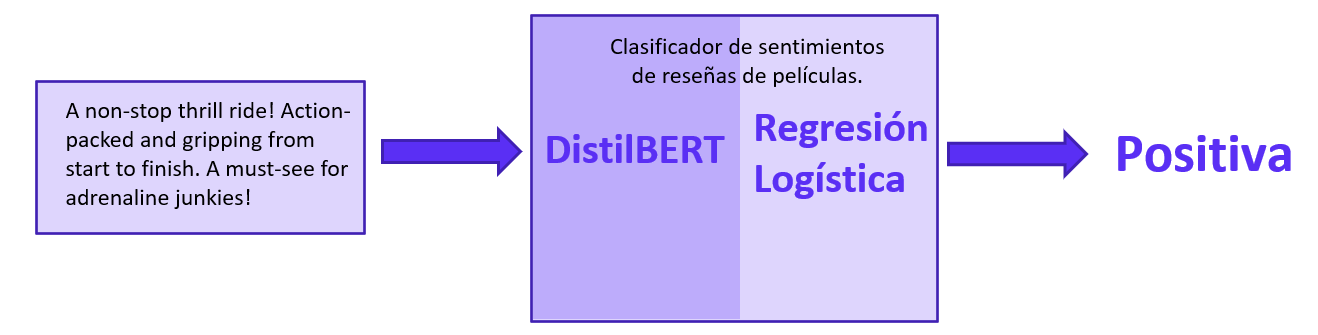
## 2.0 Base de datos

El conjunto de datos que utilizaremos en este ejemplo es [SST2](https://nlp.stanford.edu/sentiment/index.html). Esta es una base de datos del grupo de NLP de la universidad de Stanford que contiene oraciones de reseñas de películas, cada una etiquetada como positiva (tiene el valor 1) o negativa (tiene el valor 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    oración
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

Ahora importamos todas las librerias necesarias 

In [1]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

## 2.1 Importación de la base de datos

Usaremos la libreria Pandas para leer la base da datos y convertirla en un dataframe

In [2]:
#Descargamos la base de datos
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

Por razones de rendimiento, solo utilizaremos 2,000 oraciones del conjunto de datos.

In [3]:
#Subconjunto de la base de datos que utilizaremos
batch_1 = df[:2000]

Podemos preguntar a pandas cuántas oraciones están etiquetadas como "positivas" (valor 1) y cuántas están etiquetadas como "negativas" (con el valor 0).

In [4]:
batch_1[1].value_counts()

1    1041
0     959
Name: 1, dtype: int64

## 3.0 Cargando el modelo BERT preentrenado

Ahora carguemos un modelo BERT preentrenado.DistilBERT es un modelo desarrollado por el equipo de Hugging Face, pueden encontrar el artículo original donde se propuso [aquí](https://arxiv.org/pdf/1910.01108.pdf). Es una versión 'destiliada' del célebre modelo BERT y se entrenó utilizando un procedimiento conocido como 'destilación'.

La destilación de conocimientos es una técnica en la que un modelo más pequeño (alumno) se entrena para imitar el comportamiento de un modelo más grande (profesor). En el caso de DistilBERT, reduce el tamaño del modelo BERT en un 40%, haciéndolo más liviano y rápido, al tiempo que conserva el 97% de las capacidades de comprensión del lenguaje de BERT.

Los autores demuestran que DistilBERT se desempeña bien en diversas tareas, convirtiéndolo en una opción viable para aplicaciones en tiempo real y en dispositivos. El tamaño más pequeño del modelo y el tiempo de inferencia más rápido lo hacen adecuado para tareas donde la velocidad es importante y para el uso en dispositivos móviles. Lo invitamos a leer el artículo.

Ahora sí, descargamos el modelo preentrenado.

In [5]:
# Para DistilBERT:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Cargar el modelo/tokenizador preentrenado
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

En este momento, la variable `model` contiene un modelo DistilBERT preentrenado, que es una versión más pequeña de BERT pero mucho más rápida y requiere mucho menos memoria.

## 4.0 Preparando el conjunto de datos
Antes de poder pasar nuestras oraciones a DistilBERT, necesitamos realizar un procesamiento mínimo para colocarlas en el formato que requiere.

### 4.1 Tokenización
Nuestro primer paso es tokenizar las oraciones, es decir, dividirlas en palabras y subpalabras en el formato que DistilBERT puede procesar fácilmente.

In [6]:
#Utilizamos el método tokenizer para volver tokenizar nuestra oración
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

También añadimos los token [CLS] y [SEP] para cada oración. Estos tokens indican cuándo una oración ha terminado y le dice al modelo que queremos que clasifique la oración como un todo.

### 4.2 Padding

Como nuestras oraciones pueden ser de longitudes distintas, añadimos 'tokens de relleno' a las oraciones más cortas para que todos los vectores ya tokenizados tengan exactamente la misma longitud. Este procedimiento se conoce com padding.

In [7]:
# Inicializa una variable para realizar un seguimiento de la longitud máxima
max_len = 0

# Recorre cada secuencia en la lista tokenized.values
for i in tokenized.values:
    # Verifica si la longitud de la secuencia actual es mayor que max_len
    if len(i) > max_len:
        # Actualiza max_len con la longitud de la secuencia actual si es mayor
        max_len = len(i)

# Crea una nueva matriz con las secuencias rellenadas/padded para tener la misma longitud máxima
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


Nuestro conjunto de datos está ahora en la variable `padded`, podemos ver sus dimensiones a continuación:

In [8]:
np.array(padded).shape

(2000, 59)

### 4.3 Masking
Si enviamos `padded` directamente a DistilBERT, eso podría confundirlo ligeramente. Necesitamos crear otra variable para indicarle que ignore (masking) el relleno que hemos agregado cuando esté procesando su entrada. Eso es lo que representa `attention_mask`:

In [9]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

En la siguiente figura podemos ver un resumen gráfico de lo que estamos haciendo durante el preprocesamiento de nuestros datos.

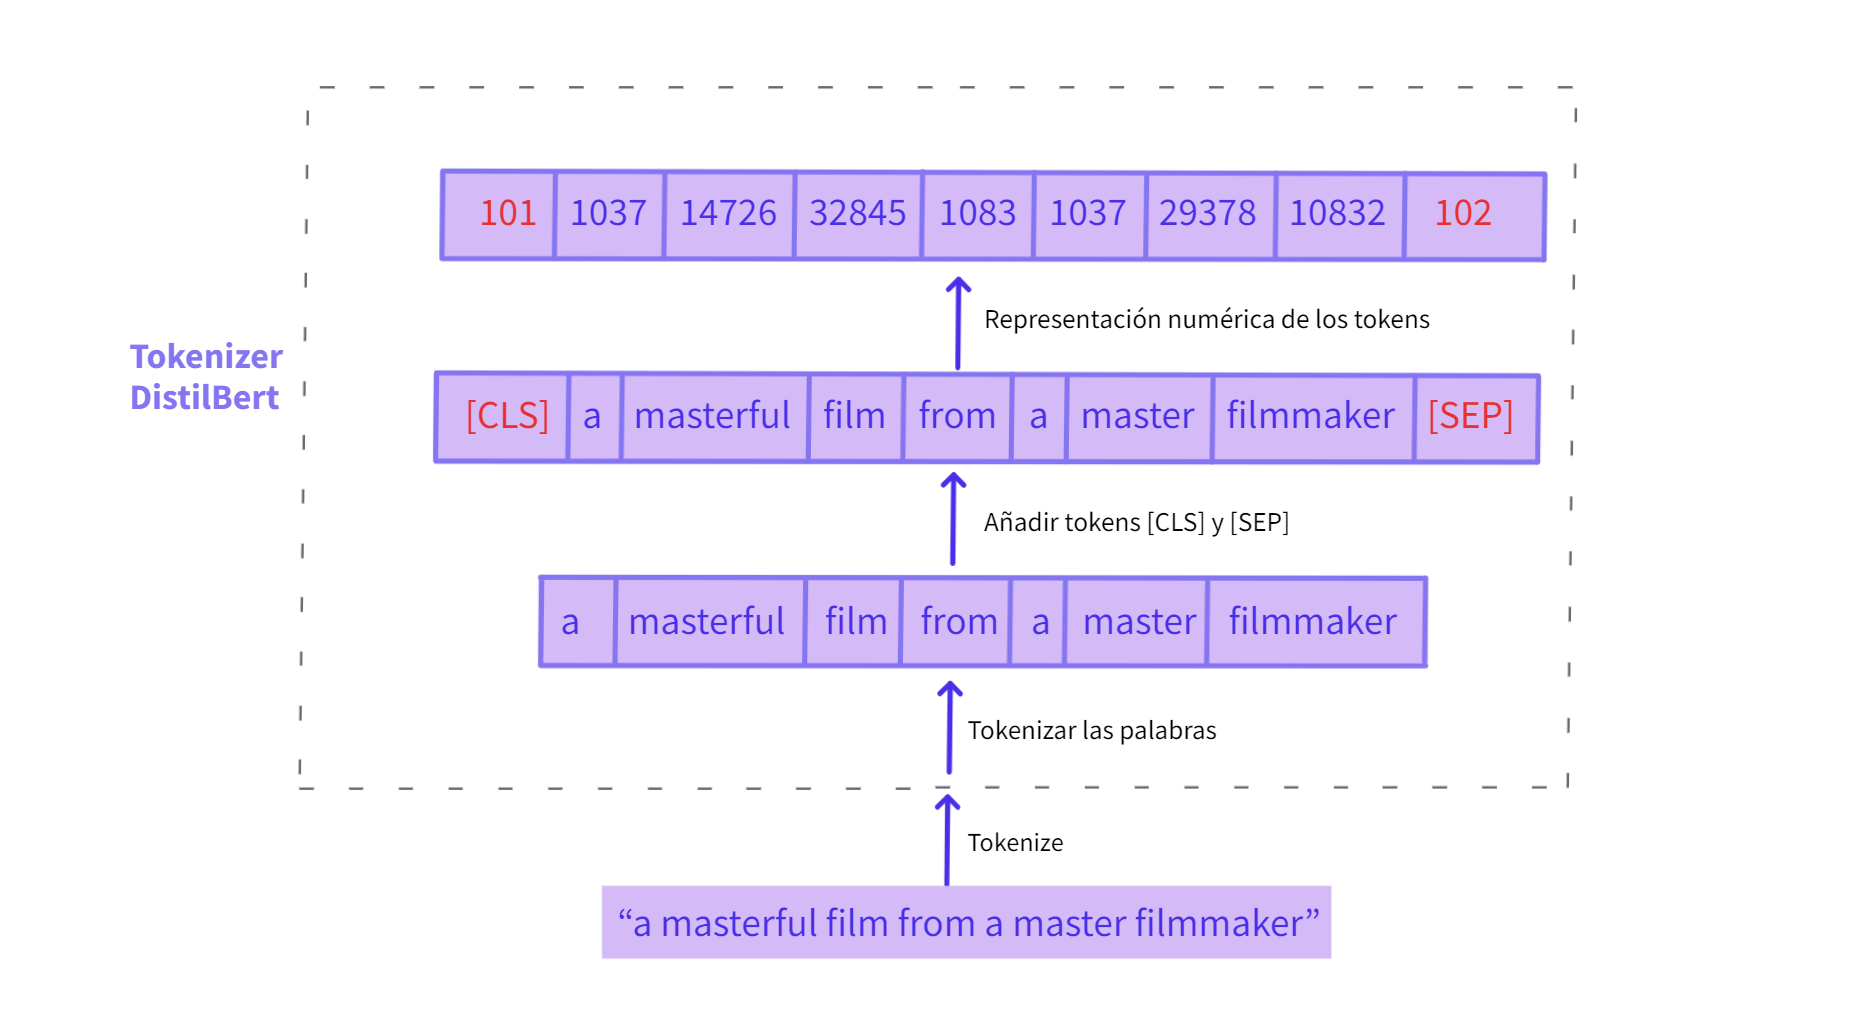

## 5.0 Primer bloque del modelo: DistilBERT
 Ahora que tenemos nuestro modelo descargado y entradas listas, vamos a ejecutar nuestro modelo DistilBERT.
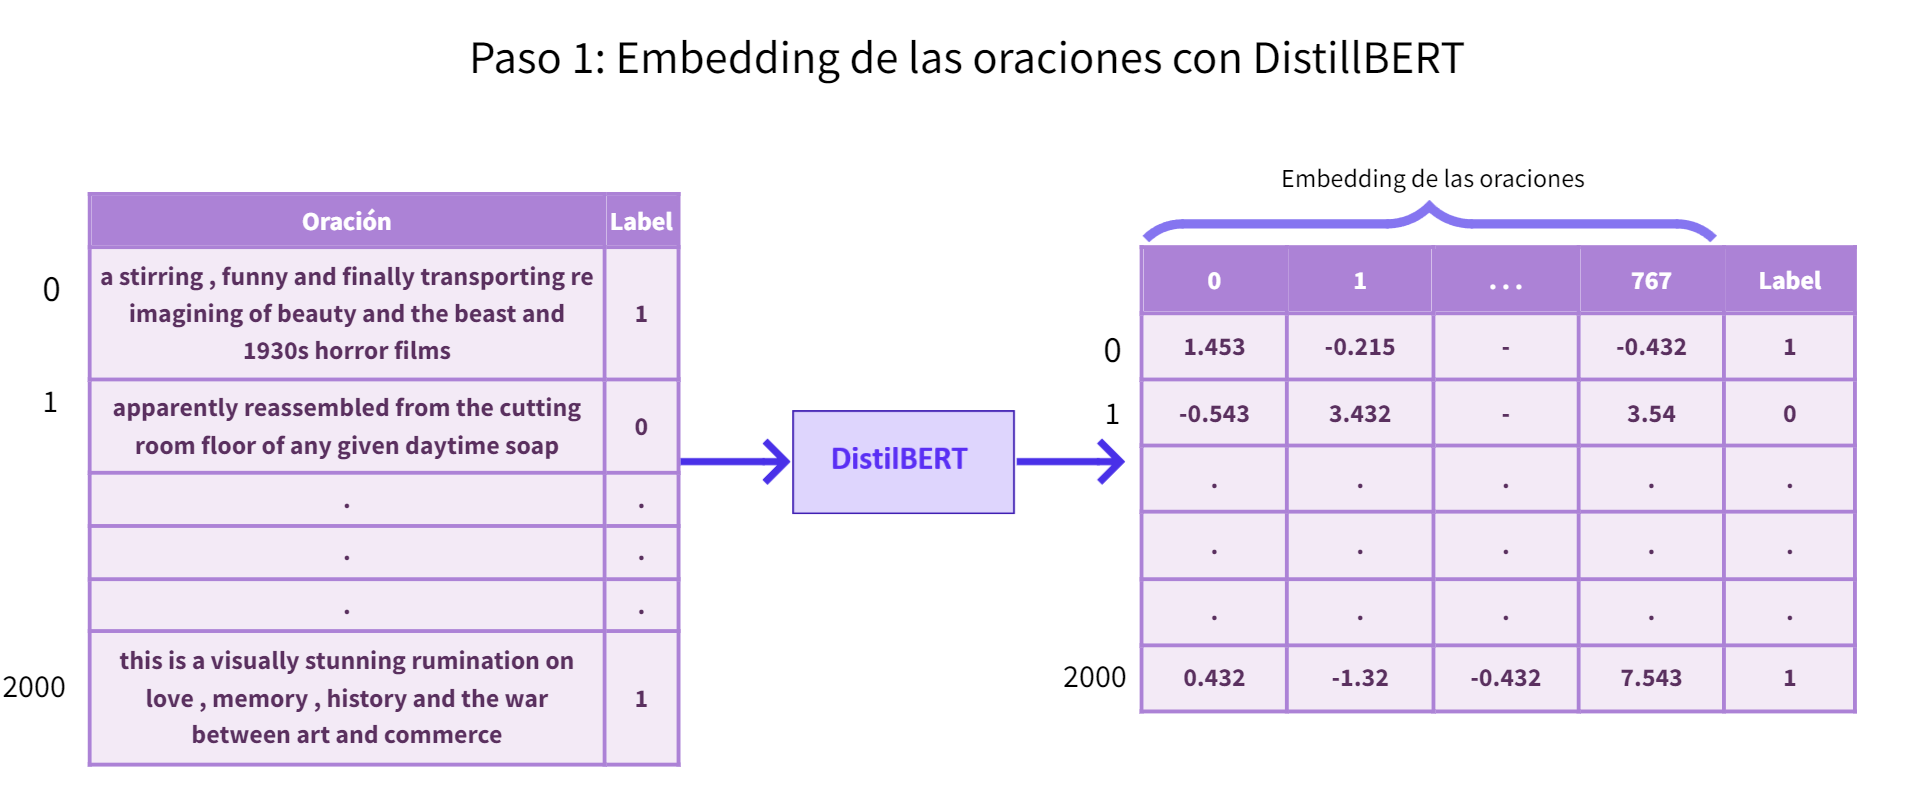
La función `model()` pasa nuestras oraciones a través de DistilBERT. Los resultados del procesamiento se devolverán en `last_hidden_states`. No entrenaremos ni haremos finetuning a DistilBERT. Simplemente lo utilizaremos en su estado preentrenado como una capa de preprocesamiento de nuestros dato, donde DistilBERT nos devuelve un embedding de nuestras oraciones en un espacio latente. Luego, estas versiones codificadas de nuestras oraciones son las que utilizaremos como entrada de nuestra regresión logística. Esto puede tardar unos minutos. 

In [10]:
# Crear tensores PyTorch para las entradas del modelo
input_ids = torch.tensor(padded)  # input_ids contiene secuencias de tokens ya procesadas y con padding
attention_mask = torch.tensor(attention_mask)  # attention_mask indica qué partes de la entrada deben ser tenidas en cuenta por el modelo

# Utilizar el modelo para obtener las últimas representaciones ocultas
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    # Usar el modelo para obtener las representaciones ocultas, evitando el cálculo de gradientes ya que no estamos entrenando aquí


Vamos a seleccionar solo la parte de la salida que necesitamos. Esa es la salida correspondiente al primer token de cada oración. La forma en que BERT realiza la clasificación de oraciones es agregando un token llamado `[CLS]` (para clasificación) al principio de cada oración. La salida correspondiente a ese token se puede considerar como un embedding para toda la oración.

Guardaremos esos valores en la variable `features`, ya que servirán como las características de nuestro modelo de regresión logística.

In [11]:
#Obtener las características (features) de interés a partir de las últimas representaciones ocultas
features = last_hidden_states[0][:,0,:].numpy()

Las etiquetas que indican qué oración es positiva y cuál es negativa ahora se almacenan en la variable `labels`.

In [12]:
labels = batch_1[1]

## 6.0 Segundo bloque del modelo: Regresión logística

### 6.1 División en conjuntos de entrenamiento y prueba 
Ahora dividamos nuestro conjunto de datos en un conjunto de entrenamiento y uno de prueba (aunque estemos utilizando 2,000 oraciones del conjunto de entrenamiento de SST2).

In [13]:
#Separamos nuestros datos en entrenamiento y prueba
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

### 6.2 Entrenamiento de la regresión logística

Ahora entrenamos el modelo de regresión logística

In [14]:
#Creamos un modelo de regresión logística
lr_clf = LogisticRegression()
#Lo entrenamos con nuestros datos de entrenamiento
lr_clf.fit(train_features, train_labels)

LogisticRegression()

### 6.3 Evaluación de nuestro clasificador 

En la siguiente celda obtenemos el valor de precisión de nuestro clasificador en el conjunto de prueba.

In [15]:
lr_clf.score(test_features, test_labels)

0.836

Además, podemos examinar el rendimiento de nuestro modelo. En la siguiente tabla, compararemos las predicciones generadas por nuestro modelo con las etiquetas reales de nuestra base de datos, todo ello en el conjunto de prueba.

In [16]:
# Predicciones en las primeras 25 oraciones del conjunto de prueba
test_predictions = lr_clf.predict(test_features[:30])

# Crear un DataFrame con oraciones, etiquetas predichas y etiquetas reales
results_df = pd.DataFrame({
    'Sentence': batch_1[0][:30].reset_index(drop=True),  # Restablecer el índice para que coincida con las longitudes
    'Predicted Label': test_predictions,
    'Actual Label': test_labels[:30].reset_index(drop=True)
})

# Mostrar los resultados
print(results_df)


                                             Sentence  Predicted Label  \
0   a stirring , funny and finally transporting re...                0   
1   apparently reassembled from the cutting room f...                0   
2   they presume their audience wo n't sit still f...                0   
3   this is a visually stunning rumination on love...                0   
4   jonathan parker 's bartleby should have been t...                1   
5   campanella gets the tone just right funny in t...                0   
6   a fan film that for the uninitiated plays bett...                0   
7   b art and berling are both superb , while hupp...                0   
8   a little less extreme than in the past , with ...                1   
9                        the film is strictly routine                0   
10  a lyrical metaphor for cultural and personal s...                1   
11  the most repugnant adaptation of a classic tex...                0   
12  for something as splendid looking 

**IMPORTANTE**: Por favor, ejecuta la siguiente celda y guarda el archivo CSV resultante en tu computadora. Este archivo contiene los resultados que acabamos de imprimir en la celda anterior. Asegúrate de no cambiar el nombre del archivo, ya que lo necesitarás para cargarlo en la siguiente actividad. Para descargarlo, presiona en 'Archivos del laboratorio' en la parte superior derecha y encontrarás el archivo en la carpeta '/home/jovyan/work/release/Laboratorio1TransformersDeLenguajeV3/sentiment_predictions.csv'.  

In [17]:
# Save the DataFrame to a CSV file
results_df.to_csv('sentiment_predictions.csv', index=False)